# 📌 Імпорт необхідних бібліотек

Для виконання аналізу даних, їхньої обробки, візуалізації та побудови моделей машинного навчання імпортовано такі бібліотеки:

### 🔹 Обробка даних:
- *StringIO* – для роботи з текстовими даними у вигляді файлового потоку.
- *NumPy* – для ефективної роботи з багатовимірними масивами та обчислювальними операціями.
- *pandas* – для завантаження, обробки та аналізу табличних даних.

### 🔹 Візуалізація:
- *Matplotlib* – для побудови графіків та діаграм.
- *Seaborn* – для статистичної візуалізації даних.

### 🔹 Методи машинного навчання:
- *scikit-learn*:
  - *RandomForestClassifier* – для побудови моделі класифікації на основі випадкового лісу.
  - *train_test_split* – для розділення вибірки на навчальну та тестову.
  - *LabelEncoder* – для кодування категоріальних змінних.
  - Метрики *accuracy_score*, *precision_score*, *recall_score*, *f1_score*, *roc_auc_score* – для оцінювання точності моделі.

### 🔹 Парсинг веб-даних:
- *requests* – для отримання HTML-сторінок із веб-сайтів.
- *BeautifulSoup* – для обробки HTML-коду та вилучення необхідної інформації.

### 🔹 Вимкнення системних попереджень:
- Щоб уникнути відображення зайвих попереджувальних повідомлень у процесі виконання коду, використано модуль *warnings*.


In [75]:
from io import StringIO  

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 🔍 Отримання даних із сайту  

Здійснюється підключення до веб-ресурсу та обробка отриманої інформації за допомогою *BeautifulSoup*.  


In [76]:
url = "https://data-analys.netlify.app/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

data_dict = {
    block.find("h5", class_="card-title").get_text(strip=True): 
    block.find("p", class_="card-text").get_text(strip=True)
    for block in soup.find_all("div", class_="card mb-3")[-2:]
}

print(data_dict.keys())

dict_keys(['Activity', 'Active users'])


# 📊 Підготовка та обробка даних  

Завантаження, об'єднання та очищення датасетів для подальшого аналізу. 

In [77]:
df_Active_users = pd.read_csv(StringIO(data_dict['Active users']))
df_Activity = pd.read_csv(StringIO(data_dict['Activity']))

df = df_Activity.merge(df_Active_users, how='left', on='user_id')

df['language'] = df['language'].replace('ru', 'eu')
df['activity_date'] = pd.to_datetime(df['activity_date'])
df = df.drop(df[df['total_seconds'] > df['total_seconds'].quantile(0.95)].index, axis=0).reset_index(drop=True)

print(df.info())
print(df.isna().sum())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41811 entries, 0 to 41810
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 41811 non-null  object        
 1   activity_date           41811 non-null  datetime64[ns]
 2   game_activity_name      41811 non-null  object        
 3   total_seconds           41811 non-null  int64         
 4   game_name               41811 non-null  object        
 5   language                41811 non-null  object        
 6   has_older_device_model  41811 non-null  bool          
 7   age                     41811 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(4)
memory usage: 2.3+ MB
None
user_id                   0
activity_date             0
game_activity_name        0
total_seconds             0
game_name                 0
language                  0
has_older_device_model    0
age          

,user_id,activity_date,game_activity_name,total_seconds,game_name,language,has_older_device_model,age
0,5Xx7q8xw22flTcYbZ1XZVQ==,2022-09-25,game 3: Main campaign,266,game 3,uk,False,26
1,5Xx7q8xw22flTcYbZ1XZVQ==,2022-09-25,game 3: Special events,43,game 3,uk,False,26
2,C/7YatYfa4qFbB1omZ7Jjw==,2022-09-05,game 2: Battle pass challenges,51,game 2,uk,False,52
3,C/7YatYfa4qFbB1omZ7Jjw==,2022-09-28,game 2: Battle pass challenges,846,game 2,uk,False,52
4,C/7YatYfa4qFbB1omZ7Jjw==,2022-10-13,game 2: Battle pass challenges,656,game 2,uk,False,52


# 📌 Аналіз розподілу мов користувачів  

Візуалізація кількості користувачів за мовними категоріями.  

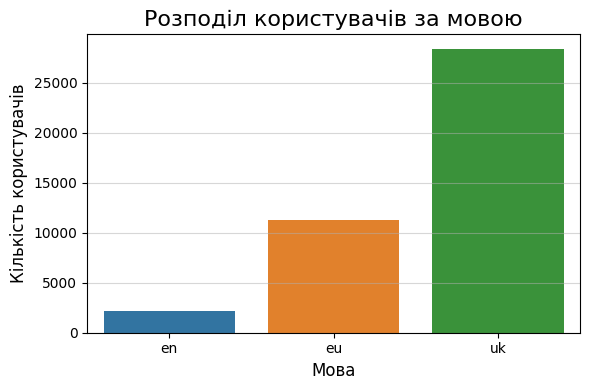

In [78]:
language = df.groupby('language')['user_id'].count()

plt.figure(figsize=(6, 4))
sns.barplot(x=language.index, y=language, hue=language.index)
plt.xlabel("Мова", fontsize=12)
plt.ylabel("Кількість користувачів", fontsize=12)
plt.title("Розподіл користувачів за мовою", fontsize=16)
plt.grid(axis="y", linestyle="-", alpha=0.5)

plt.tight_layout()

plt.show()

# 📌 Аналіз використання застарілих пристроїв  

Діаграма відображає розподіл користувачів залежно від наявності застарілої моделі пристрою.  

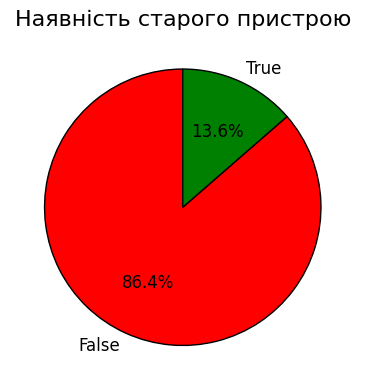

In [79]:
has_older_device = df.groupby('has_older_device_model')['user_id'].count().reset_index()

plt.figure(figsize=(6, 4))

plt.pie(
    has_older_device['user_id'], 
    labels=has_older_device['has_older_device_model'], 
    colors=["red", "green"], 
    startangle=90, 
    textprops={"fontsize": 12}, 
    wedgeprops={"linewidth": 1, "edgecolor": "black"}, 
    autopct="%1.1f%%"
)

plt.title('Наявність старого пристрою', fontsize=16)

plt.tight_layout()

plt.show()


# 📊 Динаміка активності користувачів  

### Основні метрики:  
- **DAU (Daily Active Users)** – кількість унікальних користувачів, які заходили в систему протягом дня.  
- **WAU (Weekly Active Users)** – кількість унікальних користувачів за тиждень, що допомагає оцінити стабільність залученості.  
- **MAU (Monthly Active Users)** – кількість унікальних користувачів за місяць, що дозволяє аналізувати довготривалу активність.

На графіках представлена кількість активних користувачів за день (DAU), тиждень (WAU) та місяць (MAU).  
Цей аналіз дозволяє оцінити загальний рівень активності та виявити можливі тенденції.  

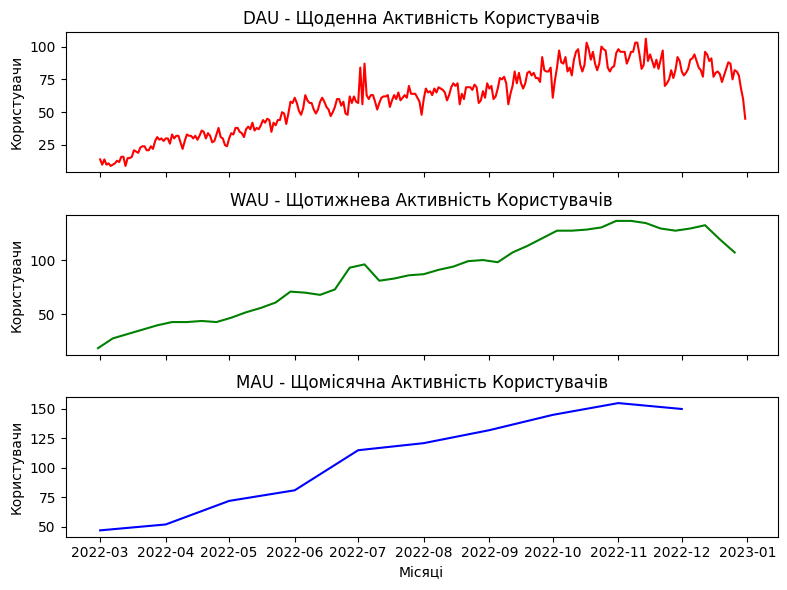

In [80]:
dau = df.groupby('activity_date')['user_id'].nunique().reset_index()

df['week_start_date'] = df['activity_date'].dt.to_period('W').apply(lambda x: x.start_time)
wau = df.groupby('week_start_date')['user_id'].nunique().reset_index()

df['month_start_date'] = df['activity_date'].dt.to_period('M').apply(lambda x: x.start_time)
mau = df.groupby('month_start_date')['user_id'].nunique().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

sns.lineplot(ax=axes[0], x=dau["activity_date"], y=dau['user_id'], color="red")
axes[0].set_title("DAU - Щоденна Активність Користувачів")
axes[0].set_ylabel("Користувачи")

sns.lineplot(ax=axes[1], x=wau["week_start_date"], y=wau['user_id'], color="green")
axes[1].set_title("WAU - Щотижнева Активність Користувачів")
axes[1].set_ylabel("Користувачи")

sns.lineplot(ax=axes[2], x=mau["month_start_date"], y=mau["user_id"], color="blue")
axes[2].set_title("MAU - Щомісячна Активність Користувачів")
axes[2].set_ylabel("Користувачи")
axes[2].set_xlabel("Місяці")

plt.tight_layout()
plt.show()

# 📉 Відношення Average DAU до WAU  

### Що аналізується?  

- **Середній DAU за тиждень** – Середня кількість щоденно активних користувачів за тиждень:  
$$ \text{Average DAU} = \frac{\sum_{i=1}^{7} DAU_i}{7} $$
- **Average DAU/WAU** – показник, що дозволяє оцінити, наскільки часто користувачі взаємодіють із системою протягом тижня. 

### Інтерпретація:  
- Значення **DAU/WAU** близьке до 1 означає, що користувачі активні майже щодня.  
- Низьке значення вказує на те, що більшість користувачів заходять лише кілька разів на тиждень.  

Цей аналіз допомагає оцінити рівень залученості користувачів та передбачати тенденції в їх поведінці.


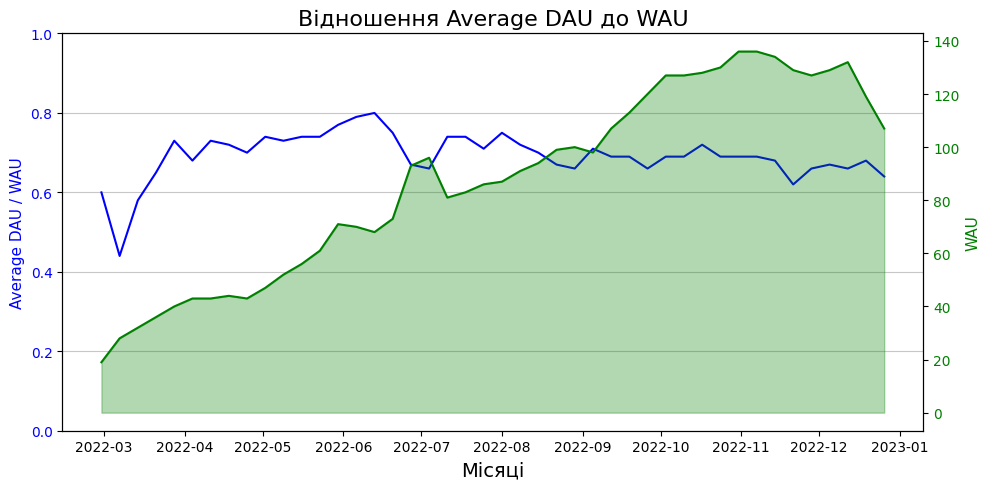

In [81]:
dau['week_start_date'] = dau['activity_date'].dt.to_period('W').apply(lambda x: x.start_time)
average_dau = dau.groupby('week_start_date')['user_id'].mean().reset_index().round(2)

dau_to_wau = (average_dau['user_id'] / wau['user_id']).round(2)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Місяці', fontsize=14)
ax1.set_ylabel('Average DAU / WAU', color='blue', fontsize=11)
ax1.plot(average_dau['week_start_date'], dau_to_wau, color='blue', label='DAU / WAU')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)
ax1.yaxis.grid(True, linestyle='-', alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel('WAU', color='green', fontsize=11)
ax2.fill_between(wau['week_start_date'], wau['user_id'], color='green', alpha=0.3)
ax2.plot(wau['week_start_date'], wau['user_id'], color='green', label='WAU')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title("Відношення Average DAU до WAU", fontsize=16)

fig.tight_layout()
plt.show()

# 🔥 Когортний аналіз користувачів  
Когортний аналіз дозволяє оцінити **утримання користувачів** за певні періоди часу, групуючи їх за місяцем першої активності.  

### Основні метрики:  
- **Кількість користувачів у кожній когорті** (теплова карта в зелених відтінках).  
- **Процент утримання користувачів** у наступні місяці після першої активності (теплова карта в синіх відтінках).  

### Інтерпретація:  
- Високе значення утримання означає, що користувачі залишаються активними протягом тривалого часу.  
- Низьке утримання вказує на можливі проблеми в залученні або зацікавленості аудиторії.  

Цей аналіз є корисним для оцінки довгострокової ефективності продукту та оптимізації користувацького досвіду.


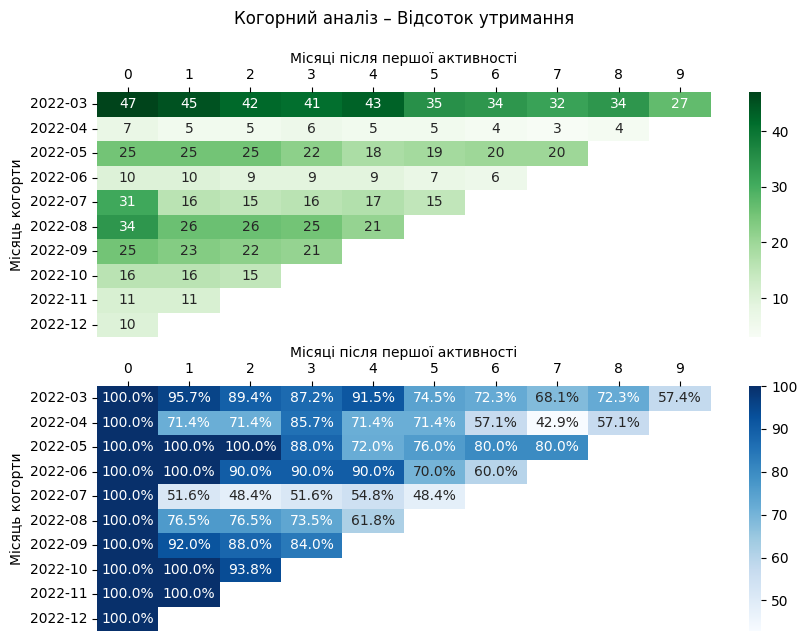

In [82]:
df['cohort_month'] = df.groupby('user_id')['activity_date'].transform('min').dt.to_period('M')
df["activity_month"] = df["activity_date"].dt.to_period("M")
df["cohort_index"] = (df["activity_month"] - df["cohort_month"]).apply(lambda x: x.n)

cohort_table = df.groupby(["cohort_month", "cohort_index"])["user_id"].nunique().unstack().fillna(0)

cohort_size = cohort_table.iloc[:, 0] 
retention_matrix = cohort_table.div(cohort_size, axis=0) * 100 

annot = retention_matrix.applymap(lambda x: f"{x:.1f}%" if x > 0 else "")

fig, axes = plt.subplots(2, 1, figsize=(7*np.sqrt(2), 7), gridspec_kw={'wspace': 0.3})

ax1 = sns.heatmap(cohort_table, annot=True, cmap="Greens", mask=cohort_table == 0, ax=axes[0])
ax1.set_title("Когорний аналіз – Відсоток утримання", pad=20)
ax1.set_xlabel("Місяці після першої активності")
ax1.set_ylabel("Місяць когорти")
ax1.xaxis.set_label_position("top")  
ax1.xaxis.tick_top()

ax2 = sns.heatmap(retention_matrix, annot=annot, fmt="", cmap="Blues", mask=retention_matrix == 0, ax=axes[1])
ax2.set_xlabel("Місяці після першої активності")
ax2.set_ylabel("Місяць когорти")
ax2.xaxis.set_label_position("top")  
ax2.xaxis.tick_top()

plt.show()

## 📉 Аналіз відтоку (Churn Rate) користувачів за іграми

Цей аналіз дозволяє оцінити **відсоток користувачів, які перестали бути активними** (відтік) для кожної гри. Це ключова метрика для розуміння довгострокової ефективності та привабливості продукту.

* **Розрахунок активності користувачів**: Визначається дата першої та останньої активності користувача, а також загальна кількість днів активності.
* **Дні з останньої активності**: Розраховується кількість днів, що минули з моменту останньої активності користувача до поточної максимальної дати в даних.
* **Тривалість життя користувача**: Визначається загальна кількість днів, протягом яких користувач був активним.
* **Визначення відтоку (Churn)**: Користувач вважається "відтіклим" (churned), якщо його остання активність була більше 7 днів тому, і при цьому він був активний щонайменше 7 днів (щоб відрізнити від тих, хто просто "заглянув").
* **Розрахунок Churn Rate по іграх**: Обчислюється відсоток відтоку для кожної окремої гри.

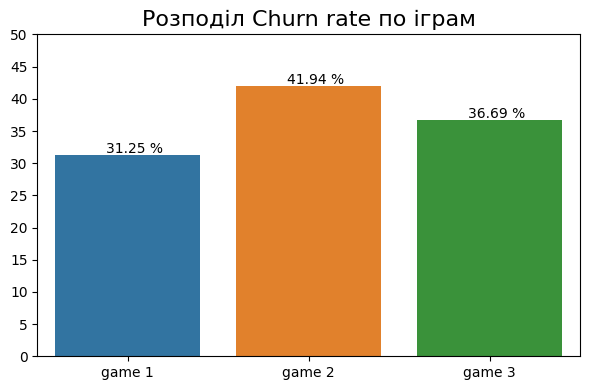

In [ ]:
# Розраховуємо статистики по користувачах
max_date = df['activity_date'].max()

user_visits = df.groupby('user_id').agg({
    'activity_date': ['min', 'max', 'nunique']
}).reset_index() 

user_visits.columns = ['user_id', 'first_activity', 'last_activity', 'total_active_days']

# Розраховуємо ключові метрики
user_visits['days_since_last_activity'] = (max_date - user_visits['last_activity']).dt.days
user_visits['user_lifetime_days'] = (user_visits['last_activity'] - user_visits['first_activity']).dt.days + 1

user_visits['churn'] = (
    (user_visits['days_since_last_activity'] > 7) & 
    (user_visits['user_lifetime_days'] >= 7)
).astype(int)

# Для повторного використання, видаляємо колонку 'churn' з основного DataFrame, якщо вона існує
if 'churn' in df.columns:
    df = df.drop('churn', axis=1)

# Додаємо churn до основного DataFrame
df = df.merge(user_visits[['user_id', 'churn']], on='user_id', how='left')

# Визначаємо унікальних користувачів
unique_users_df = df.copy()
unique_users_df.drop_duplicates(subset='user_id', inplace=True)
unique_users_df.reset_index(inplace=True)

# Розраховуємо churn rate для кожної гри
churn_rate =  (unique_users_df.groupby('game_name')['churn'].sum() 
               / 
               unique_users_df.groupby('game_name')['user_id'].nunique() * 100).round(2)

# Візуалізація кількості користувачів, які залишили гру
plt.figure(figsize=(6,4))

sns.barplot(x=churn_rate.index, y=churn_rate.values, hue=churn_rate.index)

for i, v in enumerate(churn_rate.values):
    plt.text(i-0.12, v + 0.4, f'{v} %')
    
plt.title('Розподіл Churn rate по іграм', fontsize=16)

plt.xlabel('')
plt.yticks(np.arange(0,51, 5))

# Автоматичне налаштування макету
plt.tight_layout()

plt.show()


## Визначення ключових факторів відтоку користувачів  

Ця модель **визначає, які фактори найбільше впливаають на відтік клієнтів**.  


1. **Формуються ознаки** (*features*), що можуть впливати на відтік:  
   - Вік  
   - Мова  
   - Наявність старого пристрою  
   - Різноманітність активності  
   - Кількість днів активності в грі  
   - Чи активно гравець протягом першого тижня  

2. **Навчається модель** (*Random Forest Classifier*), яка прогнозує ймовірність відтоку.  

3. Визначається важливість факторів, щоб зрозуміти, **які змінні найбільше впливають на відтік**.  



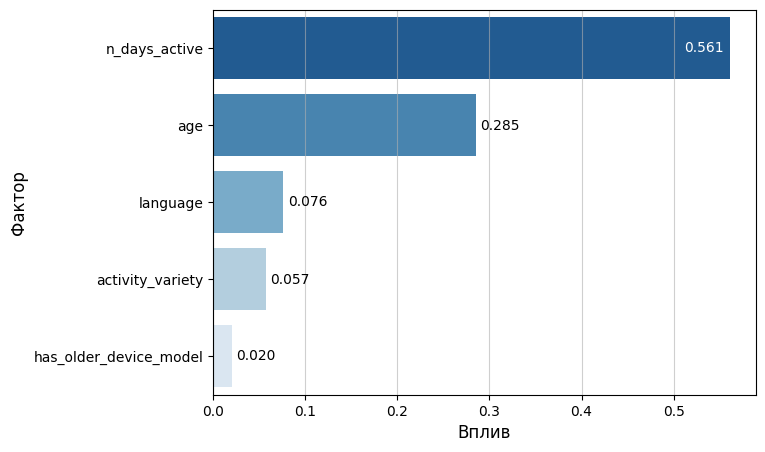

ROC-AUC: 1.0000



In [85]:
# Підрахунок кількості активних днів для кожного користувача
df['n_days_active'] = df.groupby('user_id')['activity_date'].transform('nunique')

# Підрахунок різноманітності активностей
df['activity_variety'] = df.groupby('user_id')['game_activity_name'].transform('nunique')

# Кодування категоріальних змінних --------------------------------------------------------------------------
df['language'] = LabelEncoder().fit_transform(df['language'])
df['has_older_device_model'] = df['has_older_device_model'].astype(int)

# Формування вибірки ознак і цільової змінної
features = ['age', 'language', 'has_older_device_model', 'activity_variety', 'n_days_active']
X = df[features]
y = df['churn']

# Розділення даних на тренувальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Створення та тренування моделі Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Оцінка моделі
y_pred_proba = rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.6).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba)

# Важливість ознак
feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# Побудова графіку важливості ознак
plt.figure(figsize=(7, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="Blues_r")

for index, value in enumerate(feature_importance.values):
    if value > 0.5:
        plt.text(value - 0.05, index, f"{value:.3f}", va='center', color='white')
    else: 
        plt.text(value + 0.005, index, f"{value:.3f}", va='center')

plt.xlabel('Вплив', fontsize=12)
plt.ylabel('Фактор', fontsize=12)
plt.grid(axis="x", linestyle="-", alpha=0.6)
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}\n")


#### **🔎 Висновок**  
Окрім очевидного впливу активності, **вік гравця відіграє значну роль**. Це означає, що певні вікові групи схильні до більшого або меншого відтоку, і варто адаптувати ігровий контент чи комунікацію відповідно.  

Водночас **мова, варіативність гравців та модель пристрою практично не впливають** на відтік користувачів. Це свідчить про те, що технічні обмеження чи мовні фактори не є ключовими бар'єрами для утримання аудиторії.  

In [103]:
print("Загальний розподіл віку користувачів:\n", unique_users_df['age'].describe().round(1), '\n')
print("Розподіл віку користувачів для game 1:\n", unique_users_df[unique_users_df['game_name'] == 'game 1']['age'].describe().round(1), '\n')
print("Розподіл віку користувачів для game 2:\n", unique_users_df[unique_users_df['game_name'] == 'game 2']['age'].describe().round(1), '\n')
print("Розподіл віку користувачів для game 3:\n", unique_users_df[unique_users_df['game_name'] == 'game 3']['age'].describe().round(1), '\n')

Загальний розподіл віку користувачів:
 count    216.0
mean      28.0
std       11.3
min       14.0
25%       19.0
50%       25.0
75%       34.0
max       83.0
Name: age, dtype: float64 

Розподіл віку користувачів для game 1:
 count    16.0
mean     35.6
std       8.5
min      24.0
25%      30.2
50%      34.5
75%      40.2
max      51.0
Name: age, dtype: float64 

Розподіл віку користувачів для game 2:
 count    31.0
mean     40.9
std      15.7
min      18.0
25%      28.5
50%      40.0
75%      51.0
max      83.0
Name: age, dtype: float64 

Розподіл віку користувачів для game 3:
 count    169.0
mean      24.9
std        8.2
min       14.0
25%       18.0
50%       23.0
75%       30.0
max       44.0
Name: age, dtype: float64 

